In [1]:
# does everybody really die in the summer?

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# importing data
shots = pd.read_csv('data/boston_shots_fired.csv')
shots.head()

,incident_num,incident_date,district,ballistics_evidence
0,I152000093-00,2015-01-01 04:17:00+00,C11,f
1,I152000042-00,2015-01-01 00:05:00+00,A15,f
2,I152000514-00,2015-01-02 15:51:00+00,B3,t
3,I152000965-00,2015-01-04 15:30:00+00,B2,t
4,I152000872-00,2015-01-04 00:13:00+00,B2,f


In [3]:
# cleaning up shots data

# we don't need the incident number for now
shots = shots.drop(columns=['incident_num'])

# converting the incident date to a datetime object
shots['incident_date'] = pd.to_datetime(shots['incident_date'])
shots['incident_date'] = shots['incident_date'].dt.date
shots['incident_date'] = pd.to_datetime(shots['incident_date'])

# converting t and f to 1 and 0, since this will be summed up by day later
shots['ballistics_evidence'] = shots['ballistics_evidence'].replace(['t', 'f'], [1, 0])

In [4]:
# read in weather data in 3 parts because of limitations on the NOAA API
weather1 = pd.read_csv('data/bos_weather_2015_2017.csv')
weather2 = pd.read_csv('data/bos_weather_2018_2020.csv')
weather3 = pd.read_csv('data/bos_weather_2021_2023.csv')

weather = pd.concat([weather1, weather2, weather3])

# isolating the columns we want
weather = weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
weather['DATE'] = pd.to_datetime(weather['DATE'])

<Axes: xlabel='ballistics_evidence'>

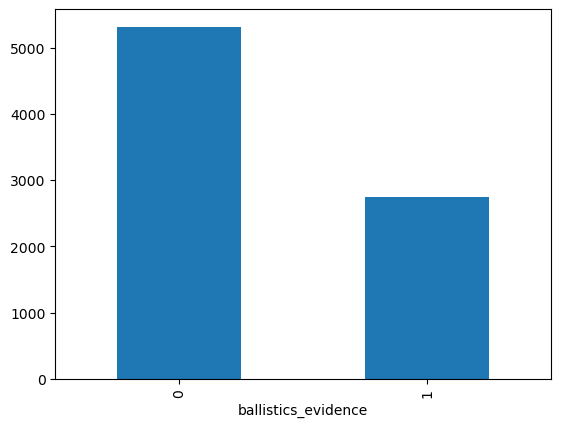

In [5]:
# curious to see how often ballistics evidence is found.
# by nature that would be pretty hard to find,
# but it's a good indicator that there was definitely a shot fired

shots['ballistics_evidence'].value_counts().plot(kind='bar')

In [6]:
# adding an incident_count column, one for each occurence
shots['incident_count'] = 1

# grouping by day and sum only the incident_count column
shots_daily = shots.groupby(['incident_date']).sum().reset_index()

In [7]:
# browsing the weather data here
weather.head()

,DATE,AWND,PRCP,SNOW,TAVG
0,2015-01-01,14.32,0.00,0.0,26
1,2015-01-02,12.75,0.00,0.0,34
2,2015-01-03,10.29,0.62,1.4,28
3,2015-01-04,8.28,0.57,0.0,38
4,2015-01-05,22.15,0.00,0.0,40


In [8]:
# merging the shots data with the weather data

# adding the shots data to the weather data
# we want to merge the shots into the weather data
# because we want an entry for every single day, even if there were no shots
weather = weather.merge(shots_daily, left_on='DATE', right_on='incident_date', how='left')

# dropping the incident_date column now that we've merged
weather = weather.drop(columns=['incident_date'])

# rewriting weather data to a new variable we'll use for now
shots_daily = weather

# replacing NaNs with 0s in the incident_count column
shots_daily['incident_count'] = shots_daily['incident_count'].fillna(0)

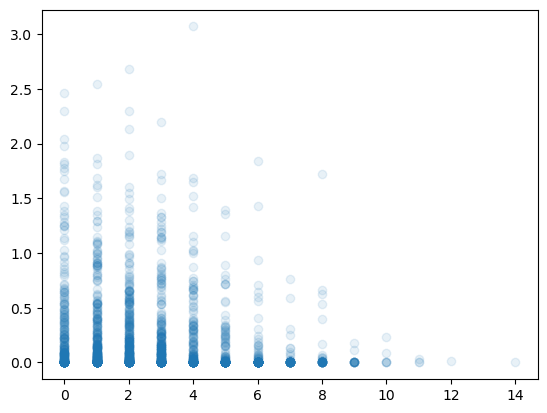

In [9]:
# let's plot the number of shots fired per day as a scatter plot, where each entry represents a shot fired
plt.scatter(shots_daily['incident_count'], shots_daily['PRCP'], alpha=0.1)

In [10]:
# we can also calculate the number of daylight hours per day.
# but as much as i'd like to take credit for the math in the function below, i cant.
# so thanks to jake vanderplas for the code below.

import datetime
def hours_of_daylight(date, latitude=42.36):
    """Compute the hours of daylight for the given date"""
    diff = date - datetime.datetime(date.year, 1, 1)
    day_of_year = diff.days + float(diff.seconds) / (24 * 60 * 60)
    days_in_year = 365.2425  # average number of days in a year, accounting for leap years
    axial_tilt = 23.44  # axial tilt of the Earth

    # Calculate the declination angle
    declination = axial_tilt * np.sin(np.radians(360.0 * (day_of_year + 10) / days_in_year))

    # Calculate the hour angle
    hour_angle = np.arccos(-np.tan(np.radians(latitude)) * np.tan(np.radians(declination)))

    # Calculate the daylight hours
    daylight_hours = 2 * np.degrees(hour_angle) / 15

    return daylight_hours

# let's add the hours of daylight to the dataframe
shots_daily['daylight_hours'] = list(map(hours_of_daylight, shots_daily['DATE']))

Text(0, 0.5, 'incident count')

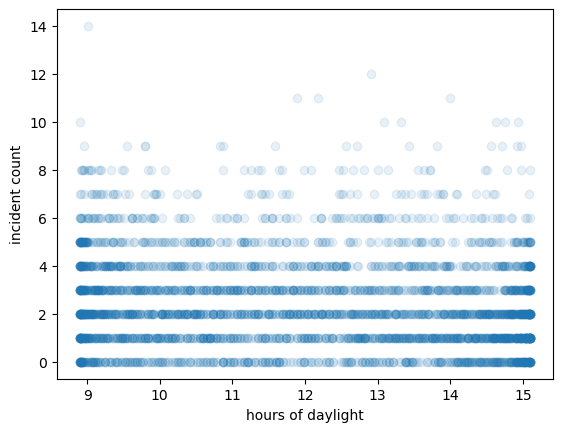

In [11]:
# plt.scatter(shots_daily['daylight_hours'], shots_daily['incident_count'], alpha=0.1)
# plt.xlabel('hours of daylight')
# plt.ylabel('incident count')

# # very interesting. on first glance, the hours of daylight doesn't seem to
# # have much of a correlation with the incident count
# # this sort of makes sense, as you may imagine that illegal activity might occur
# # more often at night, when there is less daylight

Text(0, 0.5, 'incident count')

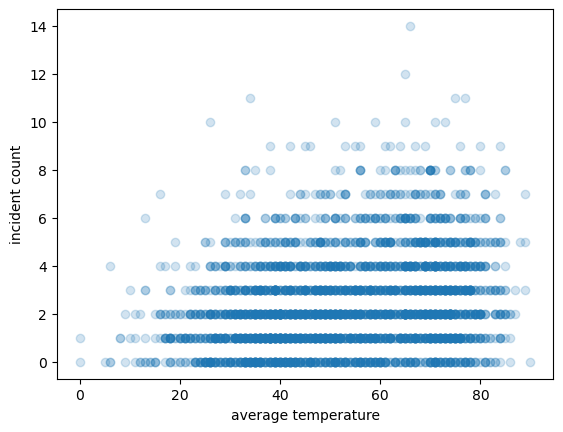

In [12]:
# the average temperature seems to have a stronger correlation with the incident count
plt.scatter(shots_daily['TAVG'], shots_daily['incident_count'], alpha=0.2)
plt.xlabel('average temperature')
plt.ylabel('incident count')

Text(0, 0.5, 'incident count')

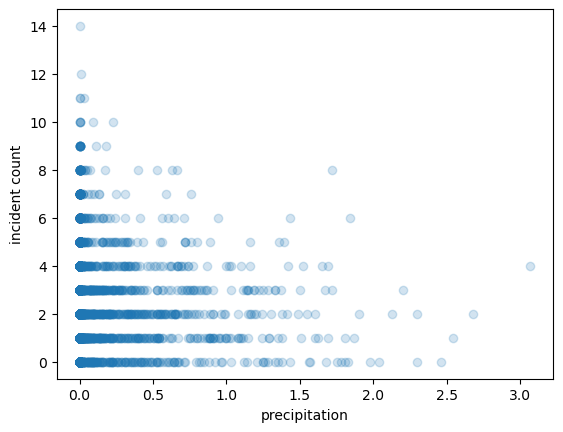

In [14]:
plt.scatter(shots_daily['PRCP'], shots_daily['incident_count'], alpha=0.2)
plt.xlabel('precipitation')
plt.ylabel('incident count')

# similarly, it looks like precipitation acts like snowfall

In [15]:
# lets organize the data by day of the week and plot the average incident count per day of the week

# adding a day of the week column
shots_daily['day_of_week'] = shots_daily['DATE'].dt.day_name()
shots_daily['day_of_week'] = pd.Categorical(shots_daily['day_of_week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

shots_daily.head()

,DATE,AWND,PRCP,SNOW,TAVG,district,ballistics_evidence,incident_count,daylight_hours,day_of_week
0,2015-01-01,14.32,0.00,0.0,26,C11A15,0.0,2.0,12.488967,Thursday
1,2015-01-02,12.75,0.00,0.0,34,B3E13,1.0,2.0,12.537565,Friday
2,2015-01-03,10.29,0.62,1.4,28,B2,0.0,1.0,12.586077,Saturday
3,2015-01-04,8.28,0.57,0.0,38,B2B2,1.0,2.0,12.634493,Sunday
4,2015-01-05,22.15,0.00,0.0,40,C6,0.0,1.0,12.682807,Monday


/var/folders/5x/1n063tsx6jx9wzcy34jzlqzh0000gn/T/ipykernel_40958/3579789719.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shots_daily_weather = shots_daily_weather.groupby(['day_of_week']).mean().reset_index()


Text(0, 0.5, 'average incident count')

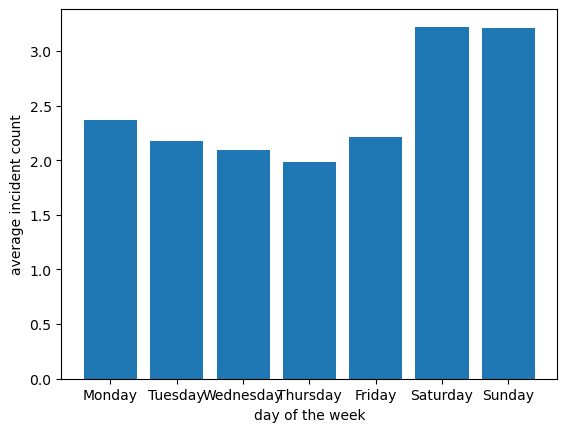

In [16]:
# averaging the incident count by day of the week
shots_daily_weather = shots_daily[['AWND', 'PRCP', 'SNOW', 'TAVG', 'incident_count', 'day_of_week']]
shots_daily_weather = shots_daily_weather.groupby(['day_of_week']).mean().reset_index()

# ploting this
plt.bar(shots_daily_weather['day_of_week'], shots_daily_weather['incident_count'])
plt.xlabel('day of the week')
plt.ylabel('average incident count')

# careful on saturdays and sundays, eh?

In [17]:
# creating a boolean column for weekend incase we use this as a feature later
shots_daily['weekend'] = shots_daily['day_of_week'].isin(['Saturday', 'Sunday'])

# also creating boolean columns for each day of the week
one_hot_encoded_data = pd.get_dummies(shots_daily['day_of_week'], prefix='is')
shots_daily = shots_daily.join(one_hot_encoded_data)
shots_daily.head()

,DATE,AWND,PRCP,SNOW,TAVG,district,ballistics_evidence,incident_count,daylight_hours,day_of_week,weekend,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday
0,2015-01-01,14.32,0.00,0.0,26,C11A15,0.0,2.0,12.488967,Thursday,False,False,False,False,True,False,False,False
1,2015-01-02,12.75,0.00,0.0,34,B3E13,1.0,2.0,12.537565,Friday,False,False,False,False,False,True,False,False
2,2015-01-03,10.29,0.62,1.4,28,B2,0.0,1.0,12.586077,Saturday,True,False,False,False,False,False,True,False
3,2015-01-04,8.28,0.57,0.0,38,B2B2,1.0,2.0,12.634493,Sunday,True,False,False,False,False,False,False,True
4,2015-01-05,22.15,0.00,0.0,40,C6,0.0,1.0,12.682807,Monday,False,True,False,False,False,False,False,False
